In [1]:
from maze_env import Maze
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import glob
import pickle

def get_latest_folder(base_name):
    index = 1
    while True:
        folder = f"{base_name}_{index}"
        if not os.path.exists(folder):
            folder = f"{base_name}_{index-1}"
            return folder
        index += 1
folder = get_latest_folder("world")

from maze_PTR_model import MazePTRModel
model = MazePTRModel()
checkpoint = torch.load(f"{folder}/models/last_model.pt")
model.load_state_dict(checkpoint)
model.eval()

# iterations
iters = 50000
initial_epsilon = 1.0
eps_anneal_rate = 0.3
alpha= 0.5
gamma = 0.99
eval_episodes = 1000
eval_steps = 100

move_penalty = 0.5

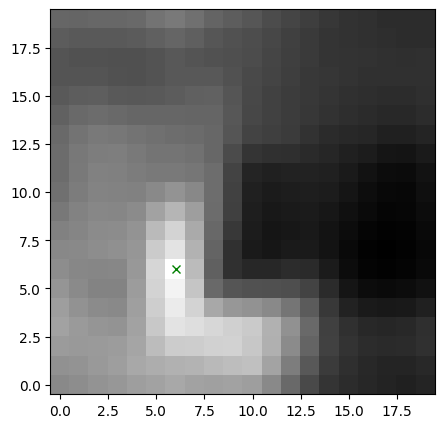

In [2]:
#Create new env with estimated reward and train agent
shrink_factor = 50
env_1 = Maze(sparse=False, model=model, move_penalty=move_penalty)
env_1.plot_reward()
#Q_2 = env_2.value_iter2(iters=iters, alpha=alpha,gamma=gamma,initial_eps=initial_epsilon, eps_anneal_rate=eps_anneal_rate,disp=True,plot_freq=1000)

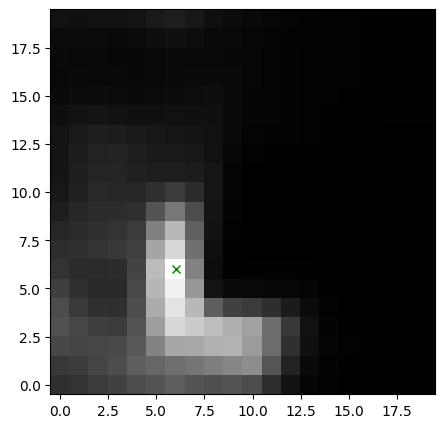

In [3]:
env_2 = Maze(sparse=False, model=model, move_penalty=move_penalty)
env_2.shrink_reward(shrink_scaling=5)
env_2.plot_reward()
#Q_3 = env_3.value_iter2(iters=iters, alpha=alpha,gamma=gamma,initial_eps=initial_epsilon, eps_anneal_rate=eps_anneal_rate,disp=True,plot_freq=1000)


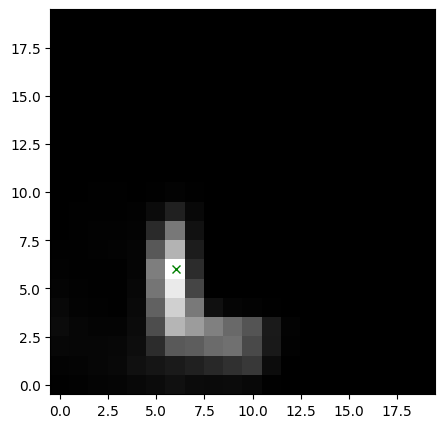

In [4]:

env_3 = Maze(sparse=False, model=model, move_penalty=move_penalty)
env_3.shrink_reward(shrink_scaling=20)
env_3.plot_reward()
#Q_4 = env_4.value_iter2(iters=iters, alpha=alpha,gamma=gamma,initial_eps=initial_epsilon, eps_anneal_rate=eps_anneal_rate,disp=True,plot_freq=1000)


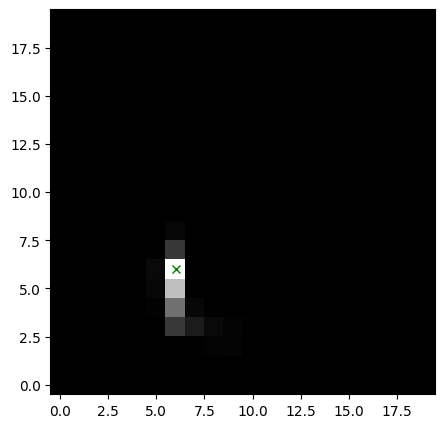

In [5]:

env_4 = Maze(sparse=False, model=model, move_penalty=move_penalty)
env_4.shrink_reward(shrink_scaling=120)
env_4.plot_reward()
#Q_5 = env_5.value_iter2(iters=iters, alpha=alpha,gamma=gamma,initial_eps=initial_epsilon, eps_anneal_rate=eps_anneal_rate,disp=True,plot_freq=1000)

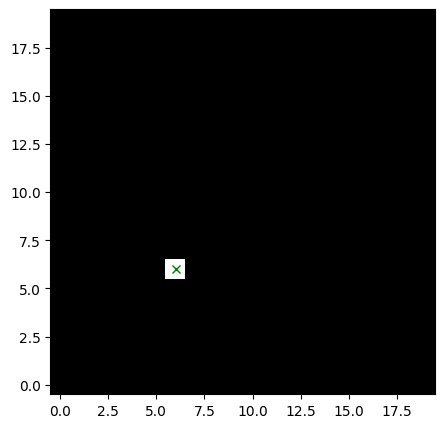

In [6]:
#Create new env with estimated reward and train agent
env_5 = Maze(sparse=True, move_penalty=move_penalty, goal_reward=100)
env_5.plot_reward()
#Q_1 = env_1.value_iter2(iters=iters, alpha=alpha,gamma=gamma,initial_eps=initial_epsilon, eps_anneal_rate=eps_anneal_rate,disp=True,plot_freq=1000)

In [7]:
# train agent on all envs, evaluate performance every 10 episodes, produce 5 arrays of performances and plot
num_episodes = 1000
eval_frequency = 20
episode_length = 500
e = 0.3
s = 300
eps = np.arange(0, num_episodes, eval_frequency)
n_Qs = 10
perf_1 = np.zeros((n_Qs, len(eps)))
perf_2 = np.zeros((n_Qs, len(eps)))
perf_3 = np.zeros((n_Qs, len(eps)))
perf_4 = np.zeros((n_Qs, len(eps)))
perf_5 = np.zeros((n_Qs, len(eps)))
perf_6 = np.zeros((n_Qs, len(eps))) # curriculum
Q_1 = torch.ones(n_Qs, env_1.Nx*env_1.Ny, env_1.action_space.shape[0])
Q_2 = torch.ones(n_Qs, env_2.Nx*env_2.Ny, env_2.action_space.shape[0])
Q_3 = torch.ones(n_Qs, env_3.Nx*env_3.Ny, env_3.action_space.shape[0])
Q_4 = torch.ones(n_Qs, env_4.Nx*env_4.Ny, env_4.action_space.shape[0])
Q_5 = torch.ones(n_Qs, env_5.Nx*env_5.Ny, env_5.action_space.shape[0])
Q_6 = torch.ones(n_Qs, env_1.Nx*env_1.Ny, env_1.action_space.shape[0]) # curriculum
curriculum_advance_episode = 220
for i in range(n_Qs):
    print(f"Repetition {i}")
    for epoch in range(len(eps)):
        print(f"epoch {epoch}, learning Q")
        Q_1[i] = env_1.train_Q_1_epoch(episodes=eval_frequency, init_Q=Q_1[i], episode_length=episode_length, alpha=alpha,gamma=gamma,final_greediness=0.5, eps_anneal=True,disp=False)
        Q_2[i] = env_2.train_Q_1_epoch(episodes=eval_frequency, init_Q=Q_2[i], episode_length=episode_length, alpha=alpha,gamma=gamma,final_greediness=0.5, eps_anneal=True,disp=False)
        Q_3[i] = env_3.train_Q_1_epoch(episodes=eval_frequency, init_Q=Q_3[i], episode_length=episode_length, alpha=alpha,gamma=gamma,final_greediness=0.5, eps_anneal=True,disp=False)
        Q_4[i] = env_4.train_Q_1_epoch(episodes=eval_frequency, init_Q=Q_4[i], episode_length=episode_length, alpha=alpha,gamma=gamma,final_greediness=0.5, eps_anneal=True,disp=False)
        Q_5[i] = env_5.train_Q_1_epoch(episodes=eval_frequency, init_Q=Q_5[i], episode_length=episode_length, alpha=alpha,gamma=gamma,final_greediness=0.5, eps_anneal=True,disp=False)
        if epoch < curriculum_advance_episode:
            Q_6[i] = env_1.train_Q_1_epoch(episodes=eval_frequency, init_Q=Q_6[i], episode_length=episode_length, alpha=alpha,gamma=gamma,final_greediness=0.5, eps_anneal=True,disp=False)
        else:
            Q_6[i] = env_5.train_Q_1_epoch(episodes=eval_frequency, init_Q=Q_6[i], episode_length=episode_length, alpha=alpha,gamma=gamma,final_greediness=0.5, eps_anneal=True,disp=False)
        print(f"epoch {epoch}, evaluating performance") 
        perf_1[i, epoch] = env_1.evaluate_Q(Q=Q_1[i], episodes=20, episode_length=s, final_greediness=1-e, eps_anneal=False, use_start_zone=False)
        perf_2[i, epoch] = env_2.evaluate_Q(Q=Q_2[i], episodes=20, episode_length=s, final_greediness=1-e, eps_anneal=False, use_start_zone=False)
        perf_3[i, epoch] = env_3.evaluate_Q(Q=Q_3[i], episodes=20, episode_length=s, final_greediness=1-e, eps_anneal=False, use_start_zone=False)
        perf_4[i, epoch] = env_4.evaluate_Q(Q=Q_4[i], episodes=20, episode_length=s, final_greediness=1-e, eps_anneal=False, use_start_zone=False)
        perf_5[i, epoch] = env_5.evaluate_Q(Q=Q_5[i], episodes=20, episode_length=s, final_greediness=1-e, eps_anneal=False, use_start_zone=False)
        perf_6[i, epoch] = env_1.evaluate_Q(Q=Q_6[i], episodes=20, episode_length=s, final_greediness=1-e, eps_anneal=False, use_start_zone=False)

Repetition 0
epoch 0, learning Q
epoch 0, evaluating performance
epoch 1, learning Q
epoch 1, evaluating performance
epoch 2, learning Q
epoch 2, evaluating performance
epoch 3, learning Q
epoch 3, evaluating performance
epoch 4, learning Q
epoch 4, evaluating performance
epoch 5, learning Q
epoch 5, evaluating performance
epoch 6, learning Q
epoch 6, evaluating performance
epoch 7, learning Q
epoch 7, evaluating performance
epoch 8, learning Q
epoch 8, evaluating performance
epoch 9, learning Q
epoch 9, evaluating performance
epoch 10, learning Q
epoch 10, evaluating performance
epoch 11, learning Q
epoch 11, evaluating performance
epoch 12, learning Q
epoch 12, evaluating performance
epoch 13, learning Q
epoch 13, evaluating performance
epoch 14, learning Q
epoch 14, evaluating performance
epoch 15, learning Q
epoch 15, evaluating performance
epoch 16, learning Q
epoch 16, evaluating performance
epoch 17, learning Q
epoch 17, evaluating performance
epoch 18, learning Q
epoch 18, eval

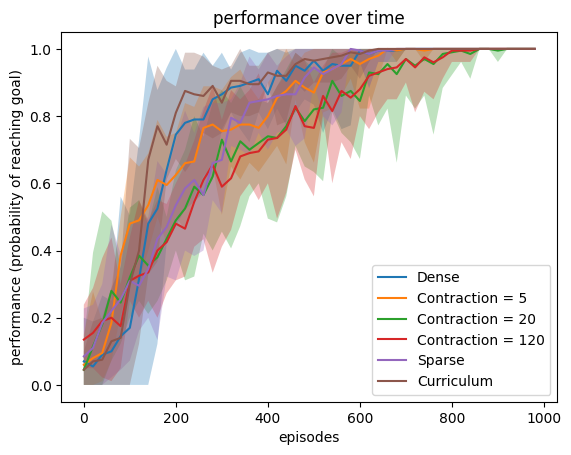

In [8]:
# put the 5 performance arrays into a single tensor
perf_1_ts = torch.tensor(perf_1)
perf_2_ts = torch.tensor(perf_2)
perf_3_ts = torch.tensor(perf_3)
perf_4_ts = torch.tensor(perf_4)
perf_5_ts = torch.tensor(perf_5)
perf_6_ts = torch.tensor(perf_6)
perf_tensor = torch.stack((perf_1_ts, perf_2_ts, perf_3_ts, perf_4_ts, perf_5_ts, perf_6_ts), dim=0)
# find the next available folder
def get_next_folder(base_name):
    index = 1
    while True:
        folder = f"{base_name}_{index}"
        if not os.path.exists(folder):
            return folder
        index += 1

# create a folder called world
eval_folder = get_next_folder(f"{folder}/evaluation")
os.mkdir(eval_folder)
# save the tensor to a file
torch.save(perf_tensor, f"{eval_folder}/performances.pt")



confidence_interval = 95
labels = ["Dense", "Contraction = 5", "Contraction = 20", "Contraction = 120", "Sparse", "Curriculum"]



perf_1_mean = np.mean(perf_1, axis=0)
perf_1_std = np.std(perf_1, axis=0)
perf_2_mean = np.mean(perf_2, axis=0)
perf_2_std = np.std(perf_2, axis=0)
perf_3_mean = np.mean(perf_3, axis=0)
perf_3_std = np.std(perf_3, axis=0)
perf_4_mean = np.mean(perf_4, axis=0)
perf_4_std = np.std(perf_4, axis=0)
perf_5_mean = np.mean(perf_5, axis=0)
perf_5_std = np.std(perf_5, axis=0)
perf_6_mean = np.mean(perf_6, axis=0)
perf_6_std = np.std(perf_6, axis=0)

perf_1_lower = np.percentile(perf_1, (100 - confidence_interval) / 2, axis=0)
perf_1_upper = np.percentile(perf_1, 100 - (100 - confidence_interval) / 2, axis=0)
perf_2_lower = np.percentile(perf_2, (100 - confidence_interval) / 2, axis=0)
perf_2_upper = np.percentile(perf_2, 100 - (100 - confidence_interval) / 2, axis=0)
perf_3_lower = np.percentile(perf_3, (100 - confidence_interval) / 2, axis=0)
perf_3_upper = np.percentile(perf_3, 100 - (100 - confidence_interval) / 2, axis=0)
perf_4_lower = np.percentile(perf_4, (100 - confidence_interval) / 2, axis=0)
perf_4_upper = np.percentile(perf_4, 100 - (100 - confidence_interval) / 2, axis=0)
perf_5_lower = np.percentile(perf_5, (100 - confidence_interval) / 2, axis=0)
perf_5_upper = np.percentile(perf_5, 100 - (100 - confidence_interval) / 2, axis=0)
perf_6_lower = np.percentile(perf_6, (100 - confidence_interval) / 2, axis=0)
perf_6_upper = np.percentile(perf_6, 100 - (100 - confidence_interval) / 2, axis=0)

plt.figure()
# Plot the mean with error bars
plt.plot(eps, perf_1_mean, label=labels[0])
plt.fill_between(eps, perf_1_lower, perf_1_upper, alpha=0.3)
plt.plot(eps, perf_2_mean, label=labels[1])
plt.fill_between(eps, perf_2_lower, perf_2_upper, alpha=0.3)
plt.plot(eps, perf_3_mean, label=labels[2])
plt.fill_between(eps, perf_3_lower, perf_3_upper, alpha=0.3)
plt.plot(eps, perf_4_mean, label=labels[3])
plt.fill_between(eps, perf_4_lower, perf_4_upper, alpha=0.3)
plt.plot(eps, perf_5_mean, label=labels[4])
plt.fill_between(eps, perf_5_lower, perf_5_upper, alpha=0.3)
plt.plot(eps, perf_6_mean, label=labels[5])
plt.fill_between(eps, perf_6_lower, perf_6_upper, alpha=0.3)

plt.xlabel("episodes")
plt.ylabel("performance (probability of reaching goal)")
plt.title("performance over time")
plt.legend()
plt.savefig(f"{eval_folder}/eval_over_time.png")
plt.show()

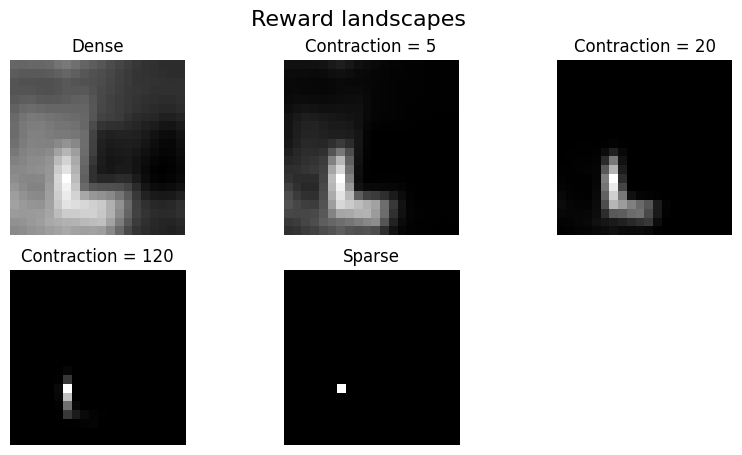

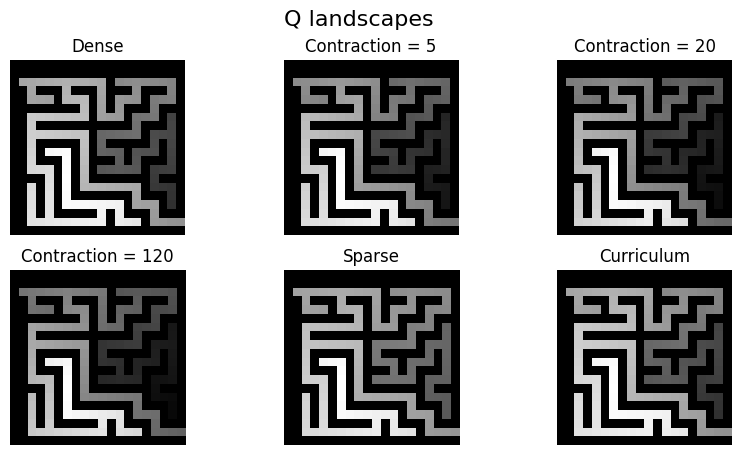

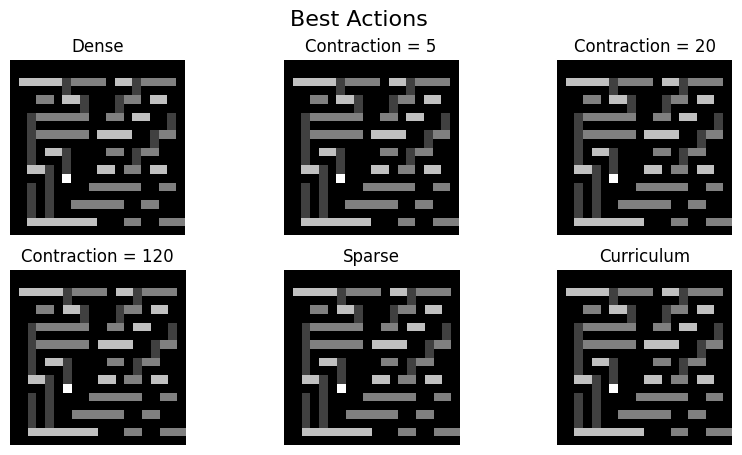

In [9]:
# create side by side subplots of the 5 reward functions
plt.figure(figsize=(10,5))
plt.suptitle("Reward landscapes", fontsize=16)
plt.subplot(2,3,1)
plt.imshow(env_1.reward_landscape.T, origin='lower', cmap='gray')
# hide the axes
plt.axis('off')
plt.title(labels[0])
plt.subplot(2,3,2)
plt.imshow(env_2.reward_landscape.T, origin='lower', cmap='gray')
plt.axis('off')
plt.title(labels[1])
plt.subplot(2,3,3)
plt.imshow(env_3.reward_landscape.T, origin='lower', cmap='gray')
plt.axis('off')
plt.title(labels[2])
plt.subplot(2,3,4)
plt.imshow(env_4.reward_landscape.T, origin='lower', cmap='gray')
plt.axis('off')
plt.title(labels[3])
plt.subplot(2,3,5)
plt.imshow(env_5.reward_landscape.T, origin='lower', cmap='gray')
plt.axis('off')
plt.title(labels[4])
plt.savefig(f"{eval_folder}/rewards_compare.png")
plt.show()


# create side by side subplots of the 6 Q functions
plt.figure(figsize=(10,5))
plt.suptitle("Q landscapes", fontsize=16)
plt.subplot(2,3,1)
plt.imshow(np.max(Q_1[0].numpy(), axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
# hide the axes
plt.axis('off')
plt.title(labels[0])
plt.subplot(2,3,2)
plt.imshow(np.max(Q_2[0].numpy(), axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
plt.axis('off')
plt.title(labels[1])
plt.subplot(2,3,3)
plt.imshow(np.max(Q_3[0].numpy(), axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
plt.axis('off')
plt.title(labels[2])
plt.subplot(2,3,4)
plt.imshow(np.max(Q_4[0].numpy(), axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
plt.axis('off')
plt.title(labels[3])
plt.subplot(2,3,5)
plt.imshow(np.max(Q_5[0].numpy(), axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
plt.axis('off')
plt.title(labels[4])
plt.subplot(2,3,6)
plt.imshow(np.max(Q_6[0].numpy(), axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
plt.axis('off')
plt.title(labels[5])
plt.savefig(f"{eval_folder}/Q_compare.png")
plt.show()


# create side by side subplots of the 5 Q functions
plt.figure(figsize=(10,5))
plt.suptitle("Best Actions", fontsize=16)
plt.subplot(2,3,1)
plt.imshow(np.argmax(Q_1[0].numpy(), axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
# hide the axes
plt.axis('off')
plt.title(labels[0])
plt.subplot(2,3,2)
plt.imshow(np.argmax(Q_2[0].numpy(), axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
plt.axis('off')
plt.title(labels[1])
plt.subplot(2,3,3)
plt.imshow(np.argmax(Q_3[0].numpy(), axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
plt.axis('off')
plt.title(labels[2])
plt.subplot(2,3,4)
plt.imshow(np.argmax(Q_4[0].numpy(), axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
plt.axis('off')
plt.title(labels[3])
plt.subplot(2,3,5)
plt.imshow(np.argmax(Q_5[0].numpy(), axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
plt.axis('off')
plt.title(labels[4])
plt.subplot(2,3,6)
plt.imshow(np.argmax(Q_6[0].numpy(), axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
plt.axis('off')
plt.title(labels[5])
plt.savefig(f"{eval_folder}/best_action_compare.png")
plt.show()



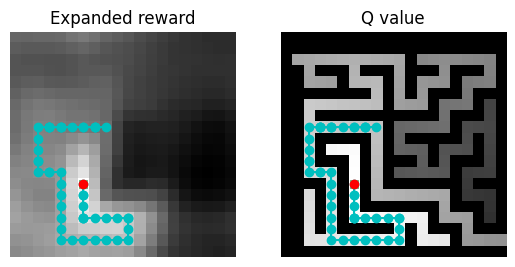

In [11]:
_, _ = env_1.test_Q_once(Q=Q_1[0].numpy(), episode_length=400, final_greediness=0.8, eps_anneal=False, use_start_zone=False, disp=True)

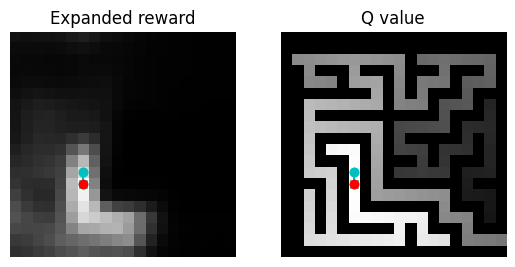

In [12]:
_, _ = env_2.test_Q_once(Q=Q_2[0].numpy(), episode_length=400, final_greediness=0.8, eps_anneal=False, use_start_zone=False, disp=True)

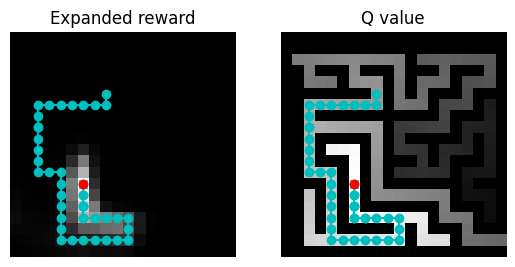

In [13]:
_, _ = env_3.test_Q_once(Q=Q_3[0].numpy(), episode_length=400, final_greediness=0.8, eps_anneal=False, use_start_zone=False, disp=True)

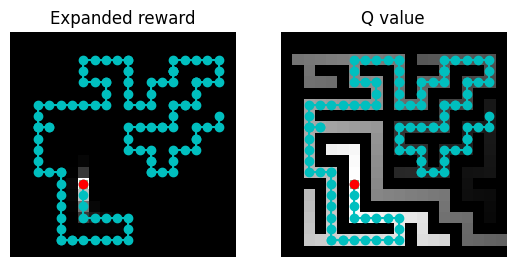

In [14]:
_, _ = env_4.test_Q_once(Q=Q_4[0].numpy(), episode_length=400, final_greediness=0.8, eps_anneal=False, use_start_zone=False, disp=True)

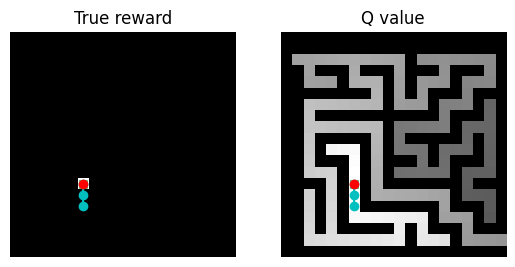

In [15]:
_, _ = env_5.test_Q_once(Q=Q_5[0].numpy(), episode_length=400, final_greediness=0.8, eps_anneal=False, use_start_zone=False, disp=True)

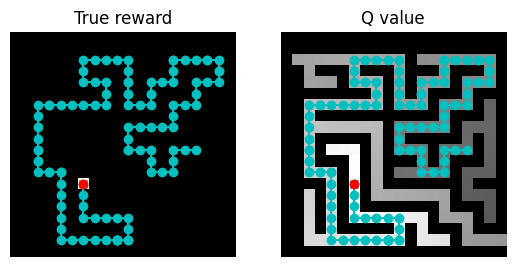

In [16]:
_, _ = env_5.test_Q_once(Q=Q_5[0].numpy(), episode_length=400, final_greediness=0.8, eps_anneal=False, use_start_zone=False, disp=True)